# Detecting Pneumonia From Chest X-Rays
Data Source: https://www.dropbox.com/s/jkgg6azweowwiaf/archive.zip?dl=0

## 1 Business Problem::

### 1.1 Description:

Pneumonia is a major cause of death worldwide, and early detection through chest X-ray imaging is crucial for effective treatment. However, manual interpretation of X-ray images by radiologists is time-consuming and subject to human error, leading to delayed diagnosis and treatment. This delay in diagnosis and treatment can lead to increased healthcare costs, prolonged hospital stays, and a higher risk of mortality.

### 1.2 Problem statment:

Identify a given X-Ray image has a pneumonia or not.

### 1.3 Real world/Business Objectives and Constraints:

1. The cost of a mis-classification can be very high. (specially when the person has a Pneumonia and model predict Normal.)
2. We want a probability or confidence for prediction.
3. Required low latency.
4. Interpretability is partially important.

# 2. Machine Learning Probelm

## 2.1 Mapping the real world problem to an ML problem
### 2.1.1 Type of Machine Leaning Problem
It is a binary classification problem, for a given X-Ray image we need to predict that preson has pneumonia or not.

2.1.2 Performance Metric
- Binary Confusion Matrix
- Precision
- Recall

# 3 Solution Provided:

Our project aims to develop an automated system for detecting pneumonia from chest X-ray images, using deep learning algorithms, to improve the speed and accuracy of pneumonia detection. This will lead to earlier diagnosis and treatment, reducing healthcare costs and improving patient outcomes.


# Enviroment setup:
Istead of running on a normal CPU, having a 'CUDA' enabled GPU helps models get trained quicker.
- 'Google's Colaboratory' is the develpoer's best friend when it comes to deep learning.
- Colaboratory is a Google research project created to help machine learning education and research.
- Hosted on Google Cloud instances which we can use free.

In this project I have trained my models on Google Colaboratory.

##Load Data:
Data is stored in a dropbox. By using below snippet of code we will get data into colaboratory.

In [1]:
# Data hosted at below link (downloading it)
!wget https://www.dropbox.com/s/jkgg6azweowwiaf/archive.zip?dl=0

# Unzipping the data
!unzip -q "archive.zip?dl=0"

--2023-01-11 11:03:40--  https://www.dropbox.com/s/jkgg6azweowwiaf/archive.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/jkgg6azweowwiaf/archive.zip [following]
--2023-01-11 11:03:40--  https://www.dropbox.com/s/raw/jkgg6azweowwiaf/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc748c9909fddc78afbe86efee97.dl.dropboxusercontent.com/cd/0/inline/B0VJK5X8wmYUnp3mNkwlwRbx4HFOp5069Wi0XO9EfWWc4OMLgu5udQBUoEGZkmFwp540TpIuO9FJFc9ruTr-XAVWXTyk3Gfn3ndp8okWuok-sbfc7puXBaHj83MaTjbn_B6EAfcLQcMM-822PG50J1bEqUb-vYQqeQxpOzUtDV7DaA/file# [following]
--2023-01-11 11:03:41--  https://uc748c9909fddc78afbe86efee97.dl.dropboxusercontent.com/cd/0/inline/B0VJK5X8wmYUnp3mNkwlwRbx4HFOp5069Wi0XO9EfWWc4OMLgu5udQBUoEGZkmFwp540TpIuO9FJFc

In [2]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from collections import Counter
%matplotlib inline

# Set the random seed in tensorflow at graph level
tf.random.set_seed(4)

In [3]:
# Creating the Pathlib PATH objects
train_path = Path("chest_xray/train/")
test_path = Path("chest_xray/test")
validation_path = Path("chest_xray/val")
print(train_path)

chest_xray/train


In [4]:
# Collecting all the Paths Inside "Normal" and "Pneumonia" folders of the above paths
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

# Output is a Generator object
print(train_image_paths)

<generator object Path.glob at 0x7f8600d23e40>


In [5]:
# Convert Generator Object to List of elements 
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

# Now the outputs are "PosixPath" objects
print(train_image_paths[:5])

[PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0465-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0579-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0681-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0955-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0239-0001.jpeg')]


In [6]:
# Convert Posix paths to normal strings
train_image_paths = list(map(lambda x : str(x) , train_image_paths))
val_image_paths = list(map(lambda x : str(x) , val_image_paths)) 

print(train_image_paths[0])

chest_xray/train/NORMAL/NORMAL2-IM-0465-0001.jpeg


In [7]:
# Collect Length for Training and Validation Datasets
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

In [8]:
# Every Image has Label in its path , so lets slice it 
LABELS = {'NORMAL' : 0 , 'PNEUMONIA' : 1}
INV_LABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'}

def get_label(path : str) -> int:
    return LABELS[path.split("/")[-2]]

train_labels = list(map(lambda x : get_label(x) , train_image_paths))
val_labels = list(map(lambda x : get_label(x) , val_image_paths))

print(train_labels[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Function for Image Preprocessing/ Augmentation/ Transformation for Training, Validation, Testing and Dataset
## Augmentation:
Data augmentation is a powerful technique which helps in almost every case for improving the robustness of a model. But augmentation can be much more helpful where the dataset is imbalanced. You can generate different samples of undersampled class in order to try to balance the overall distribution. But augmentation is a tricky part in medical imaging. We can not use most of augmentations, it might change image itself.

In [9]:
# Now we have all training, validation image paths and their respective labels 

BATCH_SIZE = 32

# Function used for Transformation
def load_and_transform(image , label , train = True):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    if train:
        image = tf.image.random_flip_left_right(image)
    return image , label

# Function used to Create a Tensorflow Data Object
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset)).shuffle(1000)

    dataset = dataset.map(lambda image , label : load_and_transform(image , label , train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

## Preparing Training data

We will first go through the training dataset. We will do some analysis on that, look at some of the samples, check the number of samples for each class, etc. Lets' do it.

Each of the above directory contains two sub-directories:

- NORMAL: These are the samples that describe the normal (no pneumonia) case.
- PNEUMONIA: This directory contains those samples that are the pneumonia cases

In [10]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(train_image_paths , train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 610 ms, sys: 470 ms, total: 1.08 s
Wall time: 2.49 s
(32, 224, 224, 3)
(32,)


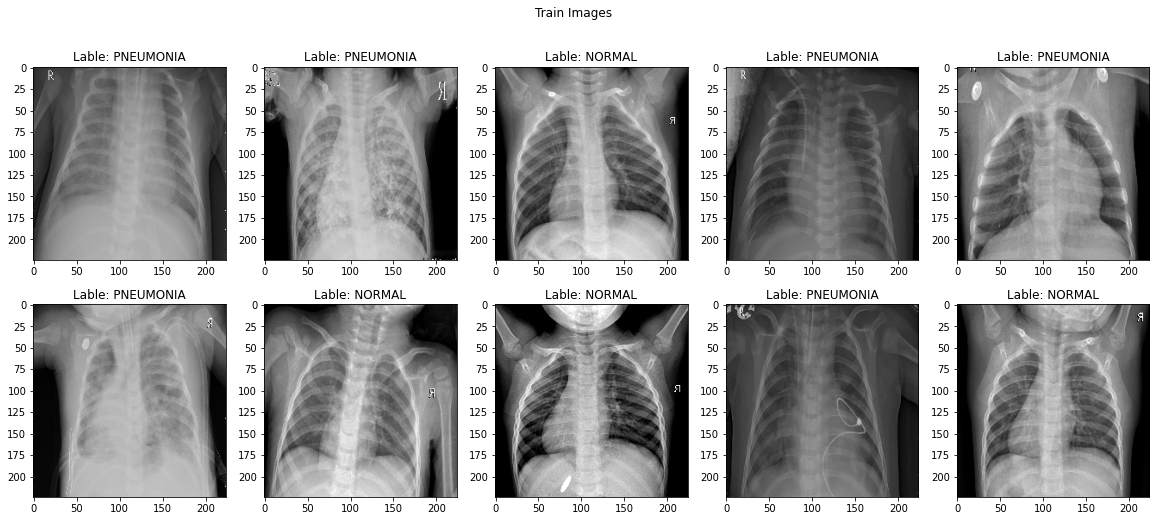

In [11]:
# View a sample Train Images
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,8))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.imshow(image[i].numpy(), cmap=plt.cm.jet)
    #plt.colorbar()
    plt.title('Lable: {}'.format(INV_LABELS[label[i].numpy()]))

#plt.tight_layout()
plt.suptitle('Train Images')
plt.show()

If you look carefully, then there are some cases where you won't be able to differentiate between a normal case and a pneumonia case with the naked eye. There is one case in the above plot, at least for me ,which is too much confusing. If we can build a robust classifier, it would be a great assist to the doctor too.

NORMAL : 1341
PNEUMONIA : 3875


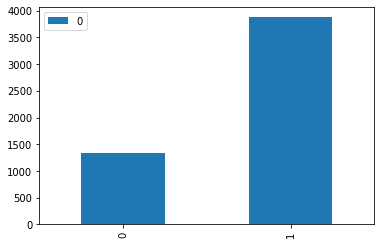

In [12]:
# # Get the counts for each class
count = Counter(train_labels)
print('NORMAL : {}'.format(count[0]))
print('PNEUMONIA : {}'.format(count[1]))

# Plot the results
df = pd.DataFrame.from_dict(count,orient='index')
df.plot(kind='bar')

As you can see the data is highly imbalanced. We have almost with thrice pneumonia cases here as compared to the normal cases. This situation is very normal when it comes to medical data. The data will always be imbalanced. either there will be too many normal cases or there will be too many cases with the disease.

## Preparing validation data

In [13]:
%time val_dataset = get_dataset(val_image_paths , val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 12.7 ms, sys: 43 µs, total: 12.7 ms
Wall time: 12.6 ms
(32, 224, 224, 3)
(32,)


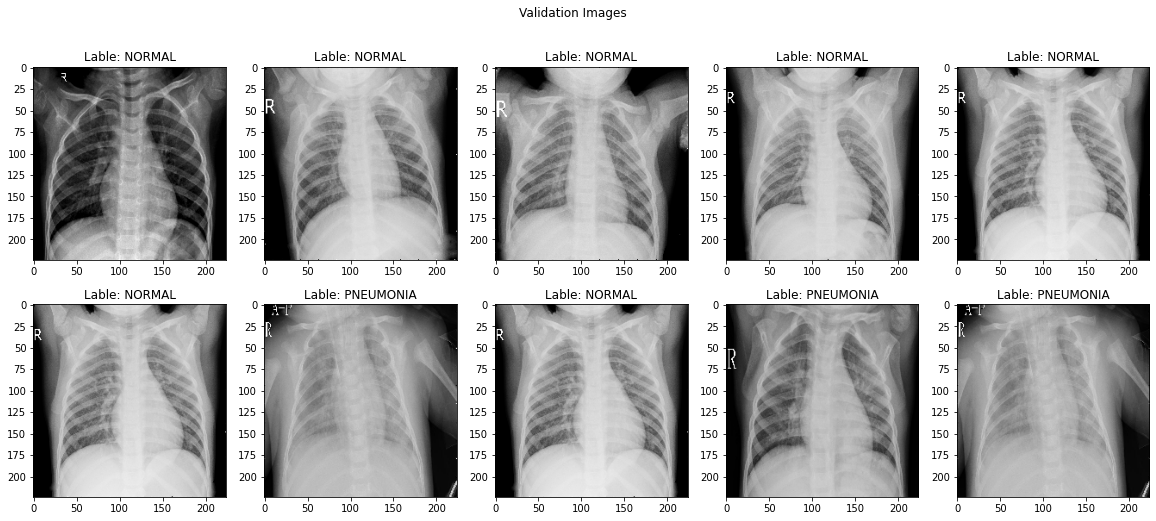

In [14]:
# View a sample Validation Images
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,8))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.imshow(image[i].numpy(), cmap=plt.cm.jet)
    #plt.colorbar()
    plt.title('Lable: {}'.format(INV_LABELS[label[i].numpy()]))

#plt.tight_layout()
plt.suptitle('Validation Images')
plt.show()

NORMAL : 8
PNEUMONIA : 8


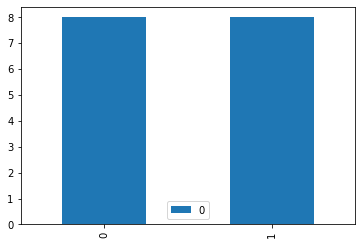

In [15]:
# # Get the counts for each class
count = Counter(val_labels)
print('NORMAL : {}'.format(count[0]))
print('PNEUMONIA : {}'.format(count[1]))
# Plot the results
df = pd.DataFrame.from_dict(count,orient='index')
df.plot(kind='bar')

# Model Building:
## Transfer Learning:
Transfer learning is a technique used in deep learning where a model trained on one task is used as the starting point for a model on a second, related task. The idea is to transfer knowledge from the first task to the second task, and use this prior knowledge to improve the performance of the second task.

Transfer learning is particularly useful when the data for the second task is limited, as it allows the model to leverage the knowledge gained from the first task to make more accurate predictions. It also allows for more efficient training, as the model can be initialized with weights that have already been trained on a similar task.

There are a few common ways to use transfer learning in deep learning:

1. Feature Extraction: The convolutional layers of a pre-trained model can be used as a feature extractor, where the output of the convolutional layers is fed into a new, task-specific classifier. This approach is useful when the data for the second task is similar to the data for the first task, and the goal is to extract useful features from the data that can be used for classification.

2. Fine-tuning: The pre-trained model can be further trained on the second task, with the goal of adapting the model to the new task. This can be done by unfreezing some or all of the layers in the pre-trained model, and training these layers on the new data.

3. Using Pre-Trained model as a Feature Extractor and fine tuning it on the target task : One of the most popular approach where we use a pre-trained model as a feature extractor and then fine-tune the network with a small amount of labeled data.

Transfer learning is widely used in computer vision, natural language processing and speech recognition, where it has been used to achieve state-of-the-art performance on a wide range of tasks using pre-trained models like BERT, GPT, etc.

Here we are using pre-trained EfficientNetB3 model. As EfficientNetB3 model trained on imagenet data with 1000 classes, we are desabling top layers so that we can use it for binary classification problem.

In [37]:
# Building ResNet50 model
from tensorflow.keras.applications import EfficientNetB3

backbone = EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 1537      
                                                                 
Total params: 10,785,072
Trainable params: 10,697,769
Non-trainable params: 87,303
_________________________________________________________________


In [38]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [39]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [40]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_length//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(val_image_paths),
)

Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9597 - precision: 0.9697 - recall: 0.9697
Epoch 1: val_loss improved from inf to 0.26412, saving model to best_weights.h5
163/163 [==============================] - 181s 876ms/step - loss: 0.1164 - accuracy: 0.9597 - precision: 0.9697 - recall: 0.9697 - val_loss: 0.2641 - val_accuracy: 0.9258 - val_precision: 0.8648 - val_recall: 1.0000
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9789 - precision: 0.9864 - recall: 0.9848
Epoch 2: val_loss improved from 0.26412 to 0.12182, saving model to best_weights.h5
163/163 [==============================] - 141s 865ms/step - loss: 0.0651 - accuracy: 0.9789 - precision: 0.9864 - recall: 0.9848 - val_loss: 0.1218 - val_accuracy: 0.9238 - val_precision: 1.0000 - val_recall: 0.8506
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9912 - precision: 0.9944 - recall: 0.9938
Epoch 

# Model Performance Visualization over the Epochs

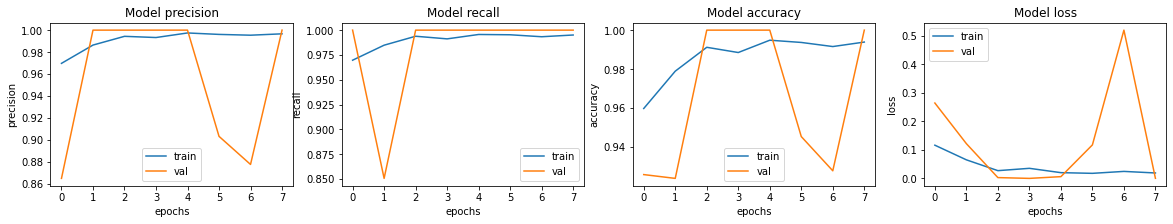

In [41]:
# Interpreting the Metrics 
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [42]:
# Saving the best Model

# Load the best weights
model.load_weights("best_weights.h5")
# Save the whole model (weigths + architecture)
model.save("model.h5")

In [43]:
# Loading the whole model
loaded_model = tf.keras.models.load_model("model.h5")

Create a Testing Dataset

In [68]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(len(test_image_paths))
)

In [69]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(624, 224, 224, 3)
(624,)


In [ ]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [46]:
# Evaluating the loaded model
loss, acc, prec, rec = loaded_model.evaluate(test_dataset,batch_size=32)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

20/20 [==============================] - 5s 152ms/step - loss: 0.7620 - accuracy: 0.8446 - precision: 0.8084 - recall: 0.9846
 Testing Acc :  0.8445512652397156
 Testing Precision  0.8084210753440857
 Testing Recall  0.9846153855323792


Nice!!! So, our model has a 98% recall. In such problems, a good recall value is expected.

When a particular problem includes an imbalanced dataset, then accuracy isn't a good metric to look for. For example, if your dataset contains 95 negatives and 5 positives, having a model with 95% accuracy doesn't make sense at all. The classifier might label every example as negative and still achieve 95% accuracy. Hence, we need to look for alternative metrics. Precision and Recall are really good metrics for such kind of problems.

We will get the confusion matrix from our predictions and see what is the recall and precision of our model.

In [47]:
preds = loaded_model.predict(test_dataset)

20/20 [==============================] - 5s 164ms/step


In [48]:
# model giving output in probabilities, we convert it into binary.
y_pred = []
for i in range(624):
  if preds[i] <= 0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)

<Figure size 432x288 with 0 Axes>

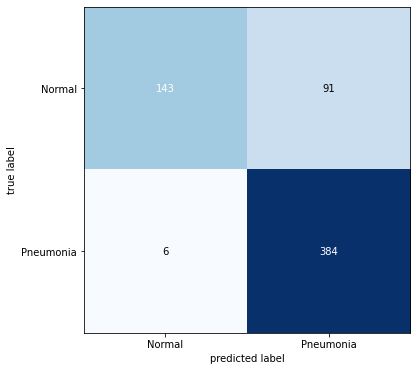

In [53]:
# Get the confusion matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(test_labels, y_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(8,6), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=10)
plt.show()

# Visualization:
Visualization of performance of a model on test dataset.

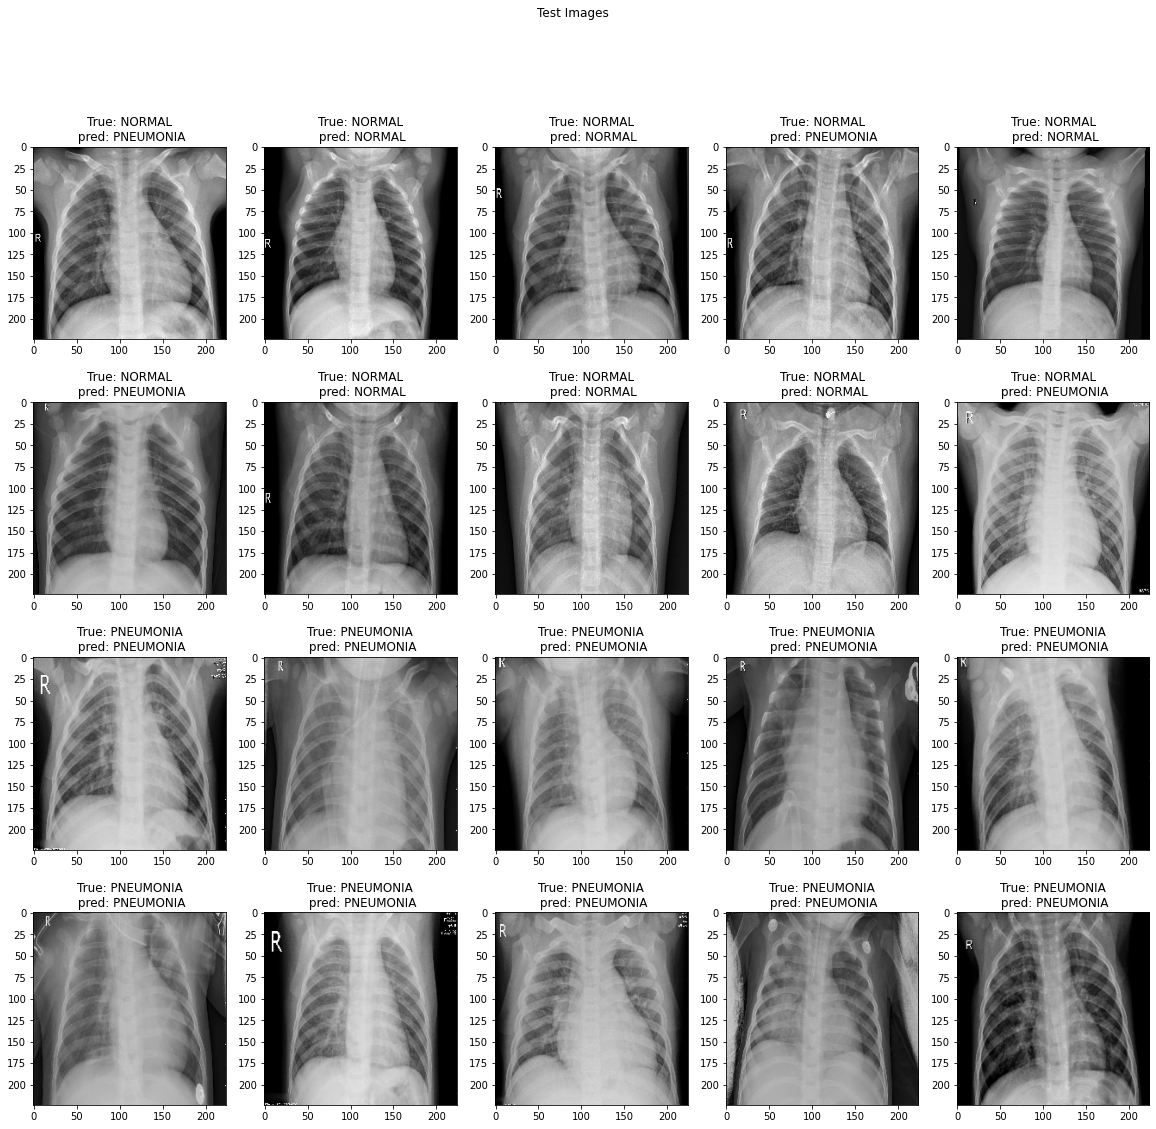

In [82]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(20,18))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.imshow(image[i+224].numpy(), cmap=plt.cm.jet)
    #plt.colorbar()
    plt.title('True: {}\n pred: {}'.format(INV_LABELS[label[i+224].numpy()],INV_LABELS[y_pred[i+224]]))

#plt.tight_layout()
plt.suptitle('Test Images')
plt.show()